In [66]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf

In [67]:
df = pd.read_csv("name_gender_dataset.csv")

df.head()

,Name,Gender,Count,Probability
0,James,M,5304407,0.014517
1,John,M,5260831,0.014398
2,Robert,M,4970386,0.013603
3,Michael,M,4579950,0.012534
4,William,M,4226608,0.011567


# Preprocessing

In [68]:
df = df.drop(["Probability", "Count"], axis=1)

df.head()

,Name,Gender
0,James,M
1,John,M
2,Robert,M
3,Michael,M
4,William,M


In [69]:
df.columns.isnull()

array([False, False])

In [70]:
df.Gender.unique()

array(['M', 'F'], dtype=object)

In [111]:
df

,Name,Gender
0,James,1
1,John,1
2,Robert,1
3,Michael,1
4,William,1
...,...,...
147264,Zylenn,1
147265,Zymeon,1
147266,Zyndel,1
147267,Zyshan,1


In [71]:
df["Gender"] = LabelEncoder().fit_transform(df.Gender.values)

## Splitting Dataset into x, y and train, test datasets

In [72]:
x_train, x_test , y_train, y_test = train_test_split(df.Name.values, df.Gender.values, test_size=0.2, random_state=2023, stratify=df.Gender.values)

In [73]:
from keras.preprocessing.sequence import pad_sequences# Create a vocabulary of alphabets
alphabet = 'abcdefghijklmnopqrstuvwxyz'
from keras.preprocessing.text import Tokenizer
vocab_size = len(alphabet)

# Convert names to vectors
tokenizer = Tokenizer(num_words=vocab_size, char_level=True)
tokenizer.fit_on_texts(x_train)

# Convert names to sequences of integers
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)


In [78]:
max_length = 10

In [79]:
x_train_padded = pad_sequences(x_train, maxlen=max_length, padding='post')
x_test_padded = pad_sequences(x_test, maxlen=max_length, padding='post')

# Model

In [80]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
model.fit(x_train_padded,y_train)

pred = model.predict(x_test_padded)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.71      0.77      0.74     17950
           1       0.59      0.50      0.54     11504

    accuracy                           0.67     29454
   macro avg       0.65      0.64      0.64     29454
weighted avg       0.66      0.67      0.66     29454



In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train,y_train)

pred = model.predict(x_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.71      0.82      0.76     17950
           1       0.63      0.47      0.54     11504

    accuracy                           0.69     29454
   macro avg       0.67      0.65      0.65     29454
weighted avg       0.68      0.69      0.68     29454



/home/lordraleigh/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
def plot_loss(history):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Binary_Cross_Entropy')
  plt.legend()
  plt.grid(True)
  plt.show()

In [106]:
import tensorflow as tf

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=15,
    mode="min",
    restore_best_weights=True,
    start_from_epoch=0,
    verbose=1,
)



model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(50, 50, input_length=10),
        tf.keras.layers.LSTM(100, activation="elu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation="elu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation="swish"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation="elu"),
        tf.keras.layers.Dense(32, activation="swish"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

In [107]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 10, 50)            2500      
                                                                 
 lstm_31 (LSTM)              (None, 100)               60400     
                                                                 
 dropout_32 (Dropout)        (None, 100)               0         
                                                                 
 dense_56 (Dense)            (None, 64)                6464      
                                                                 
 dropout_33 (Dropout)        (None, 64)                0         
                                                                 
 dense_57 (Dense)            (None, 128)               8320      
                                                                 
 dropout_34 (Dropout)        (None, 128)             

In [108]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(
    x_train_padded,
    y_train,
    batch_size=250,
    epochs=200,
    validation_split=0.2,
    verbose=1,
    callbacks=[callback],
)

Epoch 1/200
378/378 [==============================] - 9s 21ms/step - loss: 0.5521 - accuracy: 0.7197 - val_loss: 0.5105 - val_accuracy: 0.7524
Epoch 2/200
378/378 [==============================] - 7s 18ms/step - loss: 0.4885 - accuracy: 0.7701 - val_loss: 0.4763 - val_accuracy: 0.7788
Epoch 3/200
378/378 [==============================] - 7s 18ms/step - loss: 0.4778 - accuracy: 0.7764 - val_loss: 0.4685 - val_accuracy: 0.7830
Epoch 4/200
378/378 [==============================] - 7s 18ms/step - loss: 0.4714 - accuracy: 0.7791 - val_loss: 0.4706 - val_accuracy: 0.7798
Epoch 5/200
378/378 [==============================] - 7s 18ms/step - loss: 0.4688 - accuracy: 0.7808 - val_loss: 0.4588 - val_accuracy: 0.7868
Epoch 6/200
378/378 [==============================] - 8s 20ms/step - loss: 0.4624 - accuracy: 0.7840 - val_loss: 0.4555 - val_accuracy: 0.7893
Epoch 7/200
378/378 [==============================] - 8s 21ms/step - loss: 0.4584 - accuracy: 0.7857 - val_loss: 0.4547 - val_accuracy:

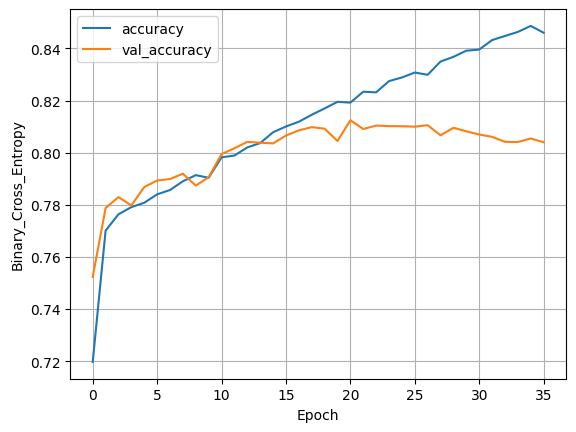

In [109]:
plot_loss(history)

In [110]:
y_pred = model.predict(x_test_padded)

for i in range(len(y_pred)):
    if y_pred[i] >= 0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0


print(classification_report(y_test, y_pred))

921/921 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       0.85      0.84      0.84     17950
           1       0.75      0.76      0.76     11504

    accuracy                           0.81     29454
   macro avg       0.80      0.80      0.80     29454
weighted avg       0.81      0.81      0.81     29454



In [124]:
a = input("Enter Name")
a = tokenizer.texts_to_sequences(a)
a = pad_sequences(a, maxlen=max_length, padding='post')
pred = model.predict(a)
if pred[0] >= 0.5:
    print("m")
else:
    print("f")

1/1 [==============================] - 0s 12ms/step
f


In [123]:
print(pred[0])

[0.6195155]
